In [213]:
import re
import time
import nltk
import logging
import requests
import secret_keys
import numpy as np
import pandas as pd

from random import randint
from bs4 import BeautifulSoup
from datetime import datetime

In [214]:
logging.basicConfig(level=logging.ERROR)

In [215]:
nltk.download(["words", "punkt", "maxent_ne_chunker", "averaged_perceptron_tagger"], quiet=True)

True

In [216]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.float_format", "{:.2f}".format)

In [217]:
verbs_dict = {
    "advanced": "",
    "increased": "",
    "rose": "",
    "changed": "",
    "unchanged": "",
    "decreased": "-",
    "fell": "-",
    "declined": "-"
}

model = {
    "finished": "JJ",
    "1982" : "CPI",
    "84=100": "CPI",
    "current": "ECON",
    "dollar": "ECON",
    "gdp": "GDP",
    "quarter": "QUAT",
    "nonfarm": "ECON", 
    "payroll": "ECON", 
    "employment": "ECON", 
    "unemployment": "ECON", 
    "consumer": "ECON",
    "producer": "ECON", 
    "price": "ECON", 
    "index": "ECON"
}

In [218]:
treebank_tagger = nltk.data.load("taggers/maxent_treebank_pos_tagger/english.pickle")
tagger = nltk.tag.UnigramTagger(model=model, backoff=treebank_tagger)

In [219]:
def get_press_release_date(text: str):
    time_regex = r"([0-9]+:[0-9]+ [A-Za-z]+)"
    date_regex = r"([A-Za-z]+ [0-9]+, [0-9]+)"
    time_match = re.search(time_regex, text.replace(".", ""))
    date_match = re.search(date_regex, text.replace(".", ""))
    time = datetime.strptime(time_match.group(1), "%H:%M %p")
    date = datetime.strptime(date_match.group(1), "%B %d, %Y")
    
    # datetime.combine(date, time.time())
    return date

In [220]:
def get_bea_press_releases(params: dict):
    press_releases = list()
    start_date = datetime.strptime("2020", "%Y").date()
    press_release_date = datetime.now().date()

    while press_release_date >= start_date:
        response = requests.get(url="https://www.bea.gov/news/archive?", params=params)
        soup = BeautifulSoup(response.content, "html.parser")
        press_release_elements = soup.find_all("tr", {"class": "release-row"})

        for element in press_release_elements:
            link_element = element.find("a")
            date_element = element.find("td", {"class": "views-field-created"})
            press_release_date = datetime.strptime(date_element.text.strip(), "%B %d, %Y").date()
            
            if press_release_date >= start_date:
                link = link_element["href"]
                press_releases.append(link)

        params["page"] += 1
    
    return press_releases

In [221]:
def get_bls_press_releases(indicator: str):
    press_releases = list()
    start_date = datetime.strptime("2020", "%Y").date()
    press_release_date = datetime.now().date()
    response = requests.get(f"https://www.bls.gov/bls/news-release/{indicator}.htm")
    soup = BeautifulSoup(response.text, "html.parser")
    news_releases = soup.find_all("a", href=re.compile(r"/news.release/archives/.*?.htm"))

    for item in news_releases:
        year_element = re.findall(r"\b\d{4}\b", item.text)[0]
        press_release_date = datetime.strptime(year_element.strip(), "%Y").date()

        if press_release_date >= start_date:
            link = item["href"]
            press_releases.append(link)

    return press_releases

In [222]:
def read_bls_press_release(link: str):
    url = f"https://www.bls.gov{link.replace('https://www.bls.gov', '')}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    press_release = soup.find("div", {"class": "normalnews"})
    press_release = " ".join(press_release.stripped_strings)
    press_release = press_release.lower()
    press_release = press_release.encode("ascii", "replace").decode()
    press_release = re.sub(r"\[|\]|\(|\)|\_|\+|\*|\"|\-|\?|\||\,", " ", press_release)
    press_release = " ".join(press_release.split())
    time.sleep(randint(0, 1))

    return press_release

In [223]:
def read_bea_press_release(link: str):
    url = f"https://www.bea.gov{link}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    header = soup.find("div", {"class": "field--name-field-release-date"}).text
    date = get_press_release_date(header)
    press_release = soup.find("div", {"class": "release-body"})
    press_release = " ".join(press_release.stripped_strings)
    press_release = press_release.lower()
    press_release = press_release.encode("ascii", "replace").decode()
    press_release = re.sub(r"\[|\]|\(|\)|\_|\+|\*|\"|\-|\?|\||\,", " ", press_release)
    press_release = " ".join(press_release.split())
    time.sleep(randint(0, 1))

    return date, press_release

In [224]:
def get_spy_daily_data(params):
    try:
        results = requests.get(url="https://www.alphavantage.co/query", params=params)
        output = results.json()
        output = [{"date": key, "open": value["1. open"], "close": value["4. close"], "volume": value["6. volume"]} for key, value in output["Time Series (Daily)"].items()]
    except Exception as e:
        logging.error(e)

    df = pd.DataFrame(output)
    df["date"] = pd.to_datetime(df["date"])
    cols = ["open", "close", "volume"]
    df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")
    time.sleep(randint(0, 1))

    return df

In [225]:
def get_gross_domestic_product_data(press_releases: list):
    output = list()

    for link in press_releases:
        date, press_release = read_bea_press_release(link)
        sentences = nltk.sent_tokenize(press_release)
        regex = r"MATCH: {<ECON>{2}<GDP><VBD|VBN><.*>*<QUAT><.*>{0,5}<CD>}"
        parser = nltk.RegexpParser(regex)

        for sentence in sentences:
            tokenized_text = nltk.word_tokenize(sentence)
            position_tags = tagger.tag(tokenized_text)
            tree = parser.parse(position_tags)

            for subtree in tree.subtrees():
                if subtree.label() == "MATCH":
                    leaves = subtree.leaves()
                    value = [val for (val, tag) in leaves if tag == "CD"][-1]
                    output.append({"date": date, "gross_domestic_product": float(value.replace(",", ""))})
                    break
            else:
                continue
            break
    
    return pd.DataFrame(output)


In [226]:
def get_nonfarm_payroll_data(press_releases: list):
    output = list()

    for link in press_releases:
        press_release = read_bls_press_release(link)
        sentences = nltk.sent_tokenize(press_release)
        regex = r"MATCH: {<ECON>{3}<VB|VBD|VBN><.*>?<CD><CD>?}"
        parser = nltk.RegexpParser(regex)

        for sentence in sentences:
            tokenized_text = nltk.word_tokenize(sentence)
            position_tags = tagger.tag(tokenized_text)
            tree = parser.parse(position_tags)
            
            for subtree in tree.subtrees():
                if subtree.label() == "MATCH":
                    leaves = subtree.leaves()
                    value = leaves[5][0]
                    
                    try:
                        assert leaves[6][0] == "million"
                        value = float(f"{value.replace(',', '')}") * 1000000.0
                    except:
                        value = float(f"{value.replace(',', '')}")
                        
                    date = get_press_release_date(press_release)
                    output.append({"date": date, "nonfarm_payroll": value})
                    break
            else:
                continue
            break
    
    return pd.DataFrame(output)

In [227]:
def get_unemployment_rate_data(press_releases: list):
    output = list()

    for link in press_releases:
        press_release = read_bls_press_release(link)
        sentences = nltk.sent_tokenize(press_release)
        regex = r"MATCH: {<ECON><NN><VBD|VBN><.*>*<CD><NN>}"
        parser = nltk.RegexpParser(regex)

        for sentence in sentences:
            tokenized_text = nltk.word_tokenize(sentence)
            position_tags = tagger.tag(tokenized_text)
            tree = parser.parse(position_tags)
            
            for subtree in tree.subtrees():
                if subtree.label() == "MATCH":
                    leaves = subtree.leaves()
                    value = [val for (val, tag) in leaves if tag == "CD"][0]
                    date = get_press_release_date(press_release)
                    output.append({"date": date, "unemployment_rate": float(value.replace(",", ""))})
                    break
            else:
                continue
            break
    
    return pd.DataFrame(output)

In [228]:
def get_producer_price_index_data(press_releases: list):
    output = list()

    for link in press_releases:
        press_release = read_bls_press_release(link)
        sentences = nltk.sent_tokenize(press_release)
        regex = r"MATCH: {<ECON>{3}<.*>{3}<VBD|VBN><CD><NN>}"
        parser = nltk.RegexpParser(regex)

        for sentence in sentences:
            tokenized_text = nltk.word_tokenize(sentence)
            position_tags = tagger.tag(tokenized_text)
            tree = parser.parse(position_tags)
            
            for subtree in tree.subtrees():
                if subtree.label() == "MATCH":
                    leaves = subtree.leaves()
                    verb = [val for (val, tag) in leaves if tag == "VBD" or tag == "VBN"][0]
                    value = [val for (val, tag) in leaves if tag == "CD"][0]
                    value = f"{verbs_dict[verb]}{value}"
                    date = get_press_release_date(press_release)
                    output.append({"date": date, "producer_price_index": float(value.replace(",", ""))})
                    break
            else:
                continue
            break
    
    return pd.DataFrame(output)

In [229]:
def get_consumer_price_index_data(press_releases: list):
    output = list()

    for link in press_releases:
        press_release = read_bls_press_release(link)
        sentences = nltk.sent_tokenize(press_release)
        regex = r"MATCH: {<CD><CPI><CPI>}"
        parser = nltk.RegexpParser(regex)

        for sentence in sentences:
            tokenized_text = nltk.word_tokenize(sentence)
            position_tags = tagger.tag(tokenized_text)
            tree = parser.parse(position_tags)
            
            for subtree in tree.subtrees():
                if subtree.label() == "MATCH":
                    leaves = subtree.leaves()
                    value = [val for (val, tag) in leaves if tag == "CD"][0]
                    date = get_press_release_date(press_release)
                    output.append({"date": date, "consumer_price_index": float(value.replace(",", ""))})
                    break
            else:
                continue
            break
    
    return pd.DataFrame(output)

In [230]:
params = {"page": 0, "created_1": "All", "field_related_product_target_id": "451"}
press_releases = get_bea_press_releases(params)
gross_domestic_product = get_gross_domestic_product_data(press_releases)

In [231]:
press_releases = get_bls_press_releases(indicator="empsit")
nonfarm_payroll = get_nonfarm_payroll_data(press_releases)

AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
press_releases = get_bls_press_releases(indicator="empsit")
unemployment_rate = get_unemployment_rate_data(press_releases)

In [ ]:
press_releases = get_bls_press_releases(indicator="ppi")
producer_price_index = get_producer_price_index_data(press_releases)

In [ ]:
press_releases = get_bls_press_releases(indicator="cpi")
consumer_price_index = get_consumer_price_index_data(press_releases)

In [ ]:
params = {"function": "TIME_SERIES_DAILY_ADJUSTED", "symbol": "SPY", "outputsize": "full", "apikey": secret_keys.alphavantage_key}
daily_spy_data = get_spy_daily_data(params)

In [ ]:
df = gross_domestic_product \
    .merge(nonfarm_payroll, on="date", how="outer") \
    .merge(unemployment_rate, on="date", how="outer") \
    .merge(consumer_price_index, on="date", how="outer") \
    .merge(producer_price_index, on="date", how="outer") \
    .merge(daily_spy_data, on="date", how="outer")

df = df[df["date"] >= "2010-01-01"]
df["weekday"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df.drop_duplicates(inplace=True, keep="last", ignore_index=True)
df.sort_values(by="date", inplace=True, ascending=True, ignore_index=True)
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

df.to_csv("s3://mle-capstone-bucket/data/final/economic-data.csv", index=False)

df.tail(20)

,date,gross_domestic_product,nonfarm_payroll,unemployment_rate,consumer_price_index,producer_price_index,open,close,volume,weekday,month
3265,2022-12-19,25.70,263000.00,3.70,297.71,0.30,383.47,380.02,79878103.00,19,12
3266,2022-12-20,25.70,263000.00,3.70,297.71,0.30,379.23,380.54,74427240.00,20,12
3267,2022-12-21,25.70,263000.00,3.70,297.71,0.30,383.25,386.23,78167369.00,21,12
3268,2022-12-22,25.70,263000.00,3.70,297.71,0.30,383.05,380.72,100120855.00,22,12
3269,2022-12-23,25.70,263000.00,3.70,297.71,0.30,379.65,382.91,59857329.00,23,12
3270,2022-12-27,25.70,263000.00,3.70,297.71,0.30,382.79,381.40,51638180.00,27,12
3271,2022-12-28,25.70,263000.00,3.70,297.71,0.30,381.33,376.66,70911520.00,28,12
3272,2022-12-29,25.70,263000.00,3.70,297.71,0.30,379.63,383.44,66970877.00,29,12
3273,2022-12-30,25.70,263000.00,3.70,297.71,0.30,380.64,382.43,84022205.00,30,12
3274,2023-01-03,25.70,263000.00,3.70,297.71,0.30,384.37,380.82,74850731.00,3,1


In [ ]:
sentence = "Total nonfarm payroll employment increased by 223,000 in December, and the unemployment \
            rate edged down to 3.5 percent, the U.S. Bureau of Labor Statistics reported today."

sentence = sentence.lower()
sentence = sentence.encode("ascii", "replace").decode()
sentence = re.sub(r"\[|\]|\(|\)|\_|\+|\*|\"|\-|\?|\||\,", " ", sentence)
sentence = " ".join(sentence.split())

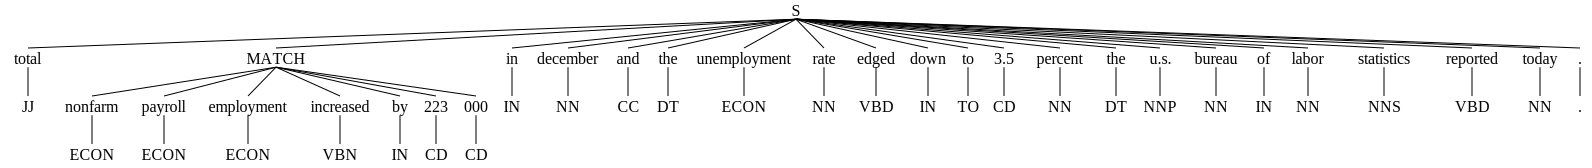

In [ ]:
regex = r"MATCH: {<ECON>{3}<VB|VBD|VBN><.*>?<CD><CD>?}"
parser = nltk.RegexpParser(regex)
tokenized_text = nltk.word_tokenize(sentence)
position_tags = tagger.tag(tokenized_text)
parser.parse(position_tags)

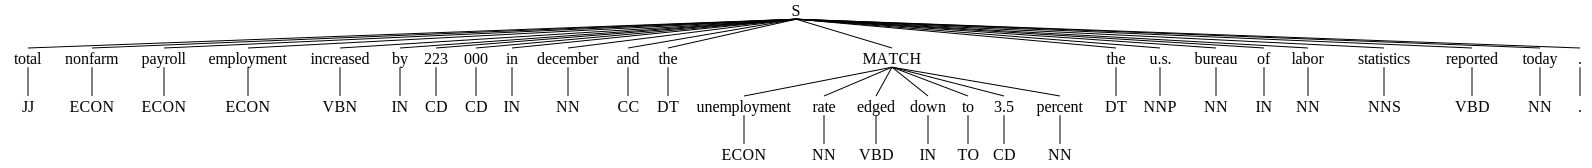

In [ ]:
regex = r"MATCH: {<ECON><NN><VBD|VBN><.*>*<CD><NN>}"
parser = nltk.RegexpParser(regex)
tokenized_text = nltk.word_tokenize(sentence)
position_tags = tagger.tag(tokenized_text)
parser.parse(position_tags)

In [ ]:
sentence = "The unemployment rate declined from 7.0 percent to 6.7 percent in December, \
    while total nonfarm payroll employment edged up (+74,000), the U.S. Bureau of Labor Statistics reported today."

sentence = sentence.lower()
sentence = sentence.encode("ascii", "replace").decode()
sentence = re.sub(r"\[|\]|\(|\)|\_|\+|\*|\"|\-|\?|\||\,", " ", sentence)
sentence = " ".join(sentence.split())

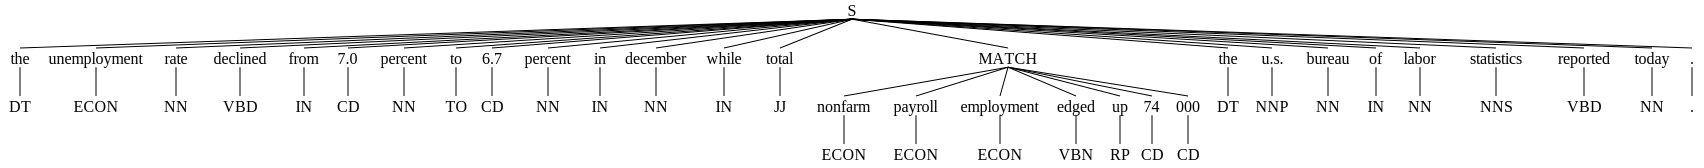

In [ ]:
regex = r"MATCH: {<ECON>{3}<VB|VBD|VBN><.*>?<CD><CD>?}"
parser = nltk.RegexpParser(regex)
tokenized_text = nltk.word_tokenize(sentence)
position_tags = tagger.tag(tokenized_text)
parser.parse(position_tags)